In [1]:
import numpy as np
import os
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [2]:
SEED = 2019
SIZE= 498
BATCH_SIZE=48

PATH = "./data/"
TRAIN_DATA_DIR = PATH + 'train'
VALIDATION_DATA_DIR = PATH + 'validation'
print(os.listdir(PATH))
print(os.listdir(TRAIN_DATA_DIR))
print(os.listdir(VALIDATION_DATA_DIR))


['.DS_Store', 'test', 'train', 'validation']
['Cat', '.DS_Store', 'NotCat']
['Cat', '.DS_Store', 'NotCat']


In [9]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
    target_size=(SIZE, SIZE), batch_size=BATCH_SIZE, class_mode='categorical',seed=SEED)

validation_generator = test_datagen.flow_from_directory(VALIDATION_DATA_DIR,
    shuffle=False, target_size=(SIZE, SIZE), batch_size=BATCH_SIZE, class_mode='categorical', seed=SEED)

Found 19650 images belonging to 2 classes.
Found 4210 images belonging to 2 classes.


In [10]:
base_model = Xception(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

In [11]:
model = Model(inputs=base_model.input, outputs=predictions)
freeze_layer_number = 109

for i, layer in enumerate(base_model.layers):
    if i <= freeze_layer_number:
        print (i,'F',base_model.layers[i])
        layer.trainable=False
    if i > freeze_layer_number:
        print (i,'T',base_model.layers[i])
        layer.trainable=True
    
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

filepath="weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

0 F <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7efaafe857f0>
1 F <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efbe83fe358>
2 F <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7efaafe16da0>
3 F <tensorflow.python.keras.layers.core.Activation object at 0x7efaafe22860>
4 F <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efaafe22eb8>
5 F <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7efabaec5940>
6 F <tensorflow.python.keras.layers.core.Activation object at 0x7efabaed7278>
7 F <tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7efabae06ba8>
8 F <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7efabada5208>
9 F <tensorflow.python.keras.layers.core.Activation object at 0x7efabad41470>
10 F <tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7efabad732e8>
11 F <tensorflow.python.keras.layers.normaliz

In [12]:
def plot_hist(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'test'])
    plt.show()

Epoch 1/8
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
408/409 [============================>.] - ETA: 1s - loss: 0.1114 - acc: 0.9724
Epoch 00001: val_acc improved from -inf to 0.98252, saving model to weights-improvement-01-0.9825.hdf5
409/409 [==============================] - 692s 2s/step - loss: 0.1116 - acc: 0.9723 - val_loss: 0.0667 - val_acc: 0.9825
Epoch 2/8
408/409 [============================>.] - ETA: 1s - loss: 0.0603 - acc: 0.9813
Epoch 00002: val_acc improved from 0.98252 to 0.98300, saving model to weights-improvement-02-0.9830.hdf5
409/409 [==============================] - 676s 2s/step - loss: 0.0604 - acc: 0.9813 - val_loss: 0.0554 - val_acc: 0.9830
Epoch 3/8
408/409 [============================>.] - ETA: 1s - loss: 0.0513 - acc: 0.9845
Epoch 00003: val_acc improved from 0.98300 to 0.98515, saving model to weights-improvement-03-0.9852.hdf5
409/409 [==============================] - 676s 2s/step - loss: 0.0513 - acc:

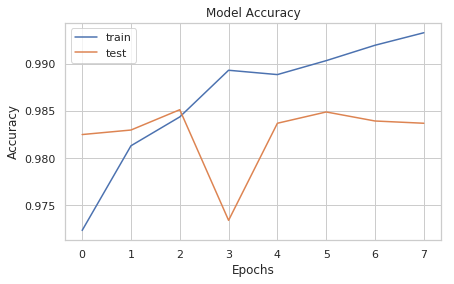

CPU times: user 3h 39min 47s, sys: 14min 28s, total: 3h 54min 16s
Wall time: 1h 30min 22s


In [13]:
%%time
hist = model.fit_generator(train_generator, train_generator.n // BATCH_SIZE, epochs=8, workers=8,
        validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, callbacks=callbacks_list)
plot_hist(hist)

In [14]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
        PATH + 'test',
        target_size=(SIZE, SIZE),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

loss, acc = model.evaluate_generator(test_generator, steps=nb_samples, verbose=0)
print(acc)

Found 4210 images belonging to 2 classes.
0.9814727


In [8]:
converter = tf.lite.TFLiteConverter.from_keras_model_file('./weights-improvement-03-0.9852.hdf5' , input_shapes={'input_2':[1, 498, 498, 3]})
tflite_model = converter.convert()
open("cat_model.tflite", "wb").write(tflite_model)

91582096

In [13]:
## BATCH_SIZE = 64, SIZE = 299
%%time
hist = model.fit_generator(train_generator, train_generator.n // BATCH_SIZE, epochs=8, workers=8,
        validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE)



Epoch 1/8
307/307 [==============================] - 169s 550ms/step - loss: 0.2069 - acc: 0.9229 - val_loss: 0.2562 - val_acc: 0.8889
Epoch 2/8
307/307 [==============================] - 168s 548ms/step - loss: 0.1256 - acc: 0.9538 - val_loss: 0.3227 - val_acc: 0.8464
Epoch 3/8
307/307 [==============================] - 168s 548ms/step - loss: 0.1140 - acc: 0.9579 - val_loss: 0.2075 - val_acc: 0.9118
Epoch 4/8
307/307 [==============================] - 168s 547ms/step - loss: 0.1044 - acc: 0.9602 - val_loss: 0.2462 - val_acc: 0.8911
Epoch 5/8
307/307 [==============================] - 168s 547ms/step - loss: 0.0959 - acc: 0.9650 - val_loss: 0.2695 - val_acc: 0.8815
Epoch 6/8
307/307 [==============================] - 167s 545ms/step - loss: 0.0932 - acc: 0.9658 - val_loss: 0.1609 - val_acc: 0.9385
Epoch 7/8
307/307 [==============================] - 168s 546ms/step - loss: 0.0836 - acc: 0.9688 - val_loss: 0.2822 - val_acc: 0.8743
Epoch 8/8
307/307 [==============================] - 16

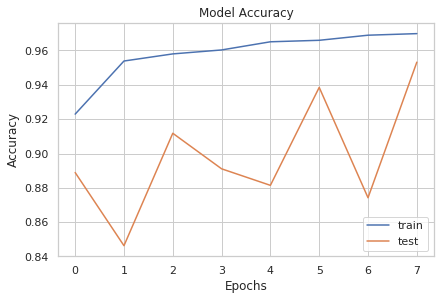

In [17]:
plot_hist(hist)